In [1]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import re

# set font size to all plots to 18
plt.rcParams.update({"font.size": 18})

In [2]:
FILE = "../data/append_tik_tok_analysis_v4_context.xlsx"

df_tk = pd.read_excel(FILE)

df_tk = df_tk.drop_duplicates(subset="link")

df_tk["scrapped_comments"] = df_tk["comments_text"].apply(
    lambda x: len(str(x).split("|"))
)
total_comments = df_tk["scrapped_comments"].sum()
print(f"Total comments: {total_comments}")

Total comments: 26244


In [3]:
first_date = df_tk["date_parsed"].min()
last_date = df_tk["date_parsed"].max()

print(f"First date: {first_date} | Last date: {last_date}")

First date: 2020-12-12 00:00:00 | Last date: 2025-03-01 00:00:00


In [4]:
stop_words = set(stopwords.words("spanish"))
stop_words.add("-")
stop_words.add("|")

for w in [
    "hacer",
    "puede",
    "puedo",
    "quiero",
    "siempre",
    "así",
    "solo",
    "0993447612ambato",
    "0989471791portoviejo",
    "0993993296uio",
    "0991584023manta",
    "0997484509provincia",
    "0997478450provincia",
    "0968923496uio",
    "0993999296uio",
]:
    stop_words.add(w)

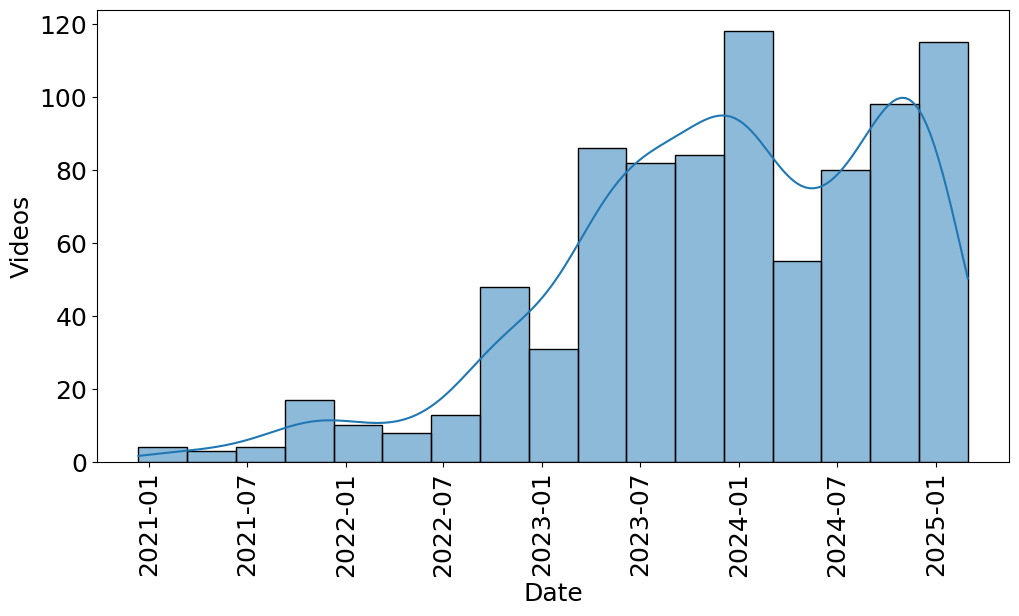

In [5]:
# plot gauss distribution of dates
sns.histplot(df_tk["date_parsed"], kde=True)
plt.tight_layout()
plt.gcf().set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Videos")
plt.xticks(rotation=90)
# rotate x labels
plt.savefig("../imgs/tik_tok_dates.png", dpi=300)

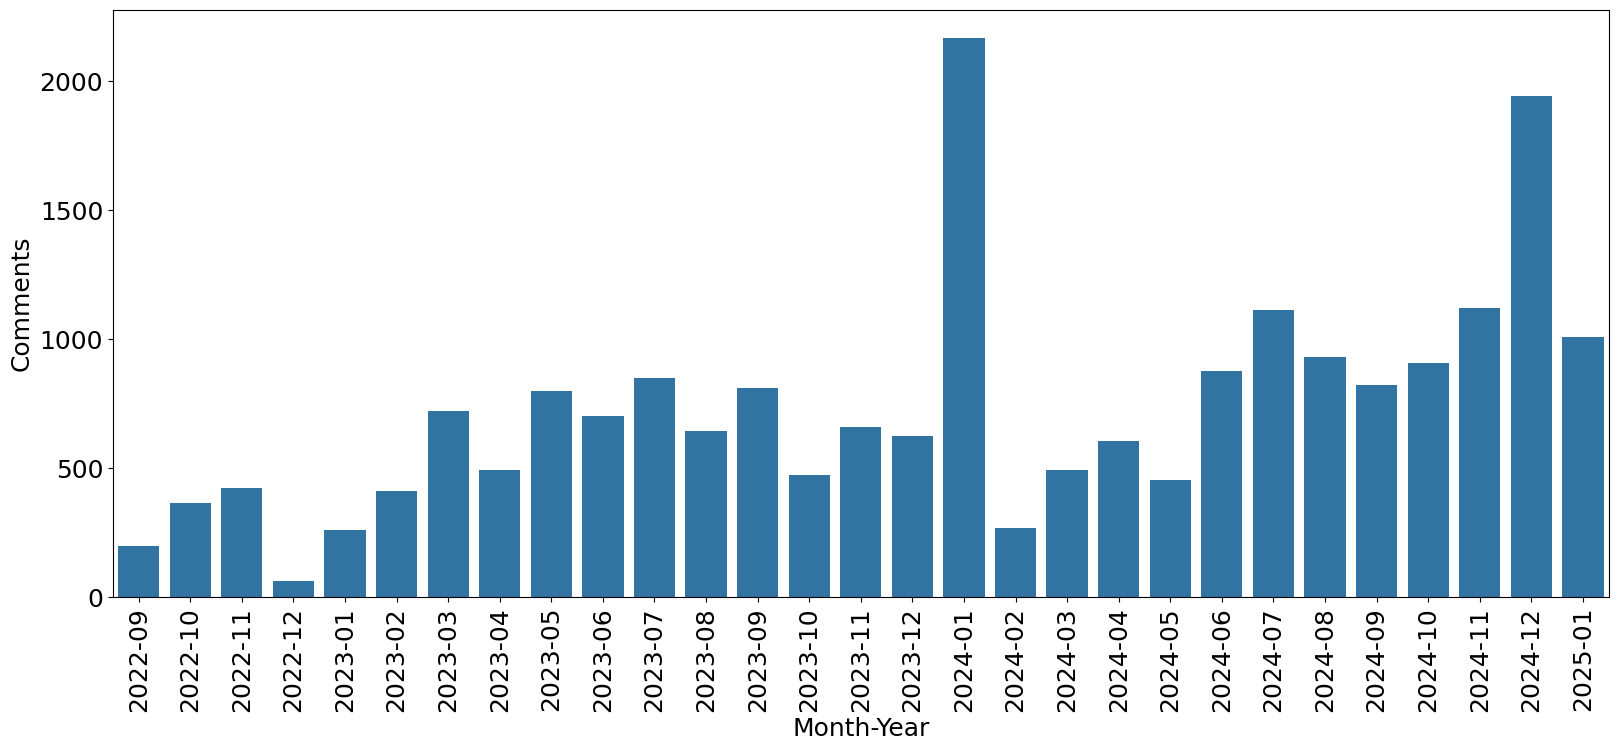

In [6]:
df_tk["month-year"] = df_tk["date_parsed"].dt.to_period("M")
df_group_month = (
    df_tk.groupby("month-year").agg({"scrapped_comments": "sum"}).reset_index()
)
df_group_month = df_group_month[(df_group_month["month-year"] != "2025-03") & (df_group_month["month-year"] != "2025-02")]

sns.barplot(
    x="month-year",
    y="scrapped_comments",
    data=df_group_month[df_group_month["month-year"] >= "2022-09"],
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.xlabel("Month-Year")
plt.ylabel("Comments")
plt.savefig("../imgs/tik_tok_month_year.png", dpi=300)

In [167]:
from typing import List


def print_plot(
    _df, target_months: List[str], min_length_word: int = 4, num_bar: int = 60
):

    print(f"-" * 50)

    target_months = [pd.Period(month) for month in target_months]

    # create plt subplots, description on left and comments on right

    # fig, axs = plt.subplots(1, 2, figsize=(30, 8))

    for idx, target_columns in enumerate(["description", "comments_text"]):

        _df[target_columns] = _df[target_columns].apply(lambda x: str(x).lower())

        def _check_stop_words(words: str) -> bool:
            word_list = words.split()

            words_allowed = []

            for word in word_list:
                word = re.sub(r"[^\w\s]", "", word).strip().lower()
                if word == "tc":
                    words_allowed.append(word)
                if (
                    word not in stop_words
                    and len(word) > min_length_word
                    and not word.startswith("@")
                ):
                    words_allowed.append(word)

            return " ".join(words_allowed)

        _df[target_columns] = _df[target_columns].apply(lambda x: _check_stop_words(x))

        _df["month-year"] = _df["date_parsed"].dt.to_period("M")

        target = _df[_df["month-year"].isin(target_months)]
        print(f"Total rows: {len(target)}")

        df_group_comments = (
            _df.groupby("month-year").agg({target_columns: " ".join}).reset_index()
        )

        words = df_group_comments[df_group_comments["month-year"].isin(target_months)][
            target_columns
        ]

        words_rows = []

        for row in words:
            words_rows.extend(row.split())

        print(f"Total words: {len(words_rows)}")

        dict_words = {}

        for word in words_rows:

            word = re.sub(r"[^\w\s]", "", word).strip()

            if word not in dict_words:

                dict_words[word] = 1

            else:

                dict_words[word] += 1

        print(
            f"Words of {len(dict_words)}",
            "0993993296uio" in dict_words.keys(),
            dict_words.keys(),
        )

        df_words = pd.DataFrame(dict_words.items(), columns=["word", "count"])

        df_words = df_words.sort_values(by="count", ascending=False)

        df_words = df_words.head(num_bar)

        fig = sns.barplot(data=df_words, x="word", y="count")

        plt.gcf().set_size_inches(16, 5)

        plt.xlabel("Word")
        plt.title(
            "Description of Tik Tok"
            if target_columns == "description"
            else "Comments of Tik Tok"
        )
        #  set x label to Word

        # tight layout
        plt.tight_layout()

        #  plt.xticks(rotation=90)
        fig.set_xticklabels(fig.get_xticklabels(), rotation=90)

        fig.set(ylabel="Count")

        print(f"Plotting {target_columns} of {target_months}")

        # wordcloud = WordCloud(
        #     width=800, height=400, background_color="white"
        # ).generate_from_frequencies(dict_words)

        # plt.figure(figsize=(12, 6))

        # plt.imshow(wordcloud, interpolation="bilinear")

        # plt.axis("off")

        # print(f"Wordcloud of {target_columns} of {target_months}")
        plt.savefig(f"../imgs/tik_tok_{target_columns}_{target_months}.png", dpi=300)

        # weed radial plot
        

        plt.show()

    # plt.show()

In [ ]:
min_length_word = 4
num_bar = 20
"""
Rangos/Picos:
1: 2022-09 -> 2022-11
2: 2023-01 -> 2023-03
3: 2023-05 -> 2023-09
4: 2023-11 -> 2024-01
5: 2024-01 (Fito mi primo)
6: 2024-03 -> 2024-04
7: 2024-06 -> 2024-08
8: 2024-11 -> 2024-12
"""
print_plot(df_tk, ["2022-09", "2022-10", "2022-11"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-01", "2023-02", "2023-03"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-05", "2023-06", "2023-07"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-07", "2023-08", "2023-09"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-11", "2023-12"], min_length_word, num_bar)
print_plot(df_tk, ["2024-01"], min_length_word, num_bar)
print_plot(df_tk, ["2024-03", "2024-04"], min_length_word, num_bar)
print_plot(df_tk, ["2024-06", "2024-07", "2024-08"], min_length_word, num_bar)
print_plot(df_tk, ["2024-11", "2024-12"], min_length_word, num_bar)

Total comments: 26244
--------------------------------------------------
['2022-09', '2022-10', '2022-11']
Total Tik Tok opinions: 833
Total Twitter opinions: 3


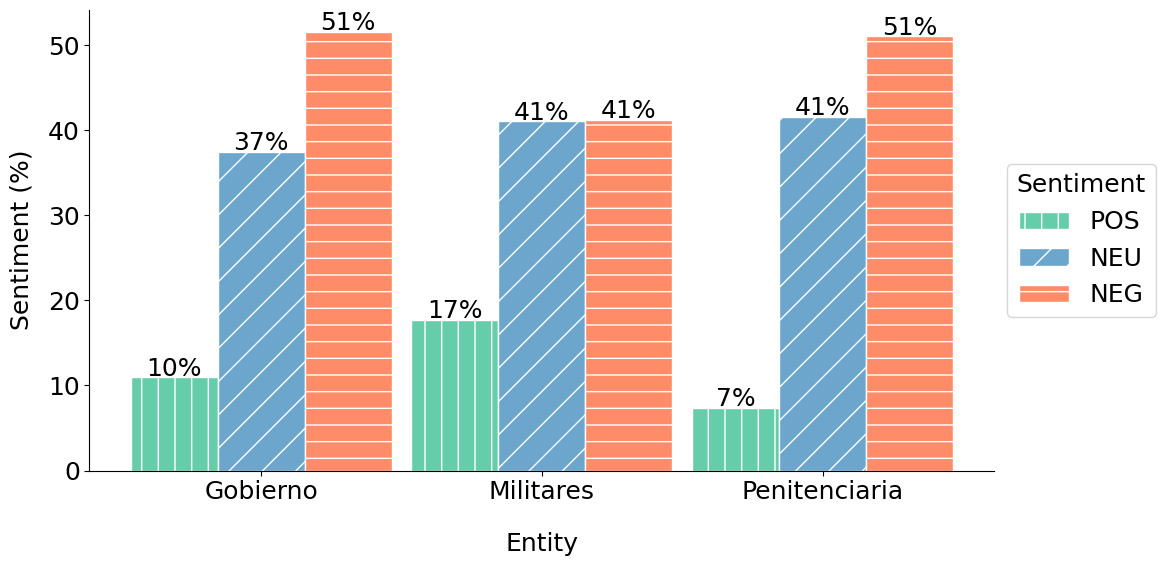

--------------------------------------------------
--------------------------------------------------
['2024-01']
Total Tik Tok opinions: 1766
Total Twitter opinions: 105


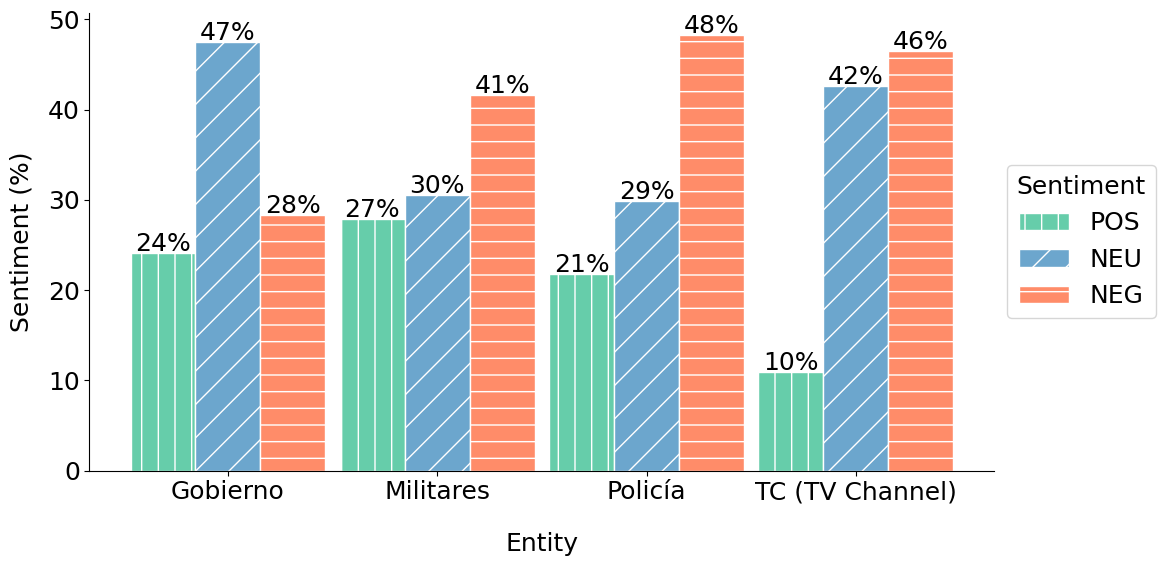

--------------------------------------------------
--------------------------------------------------
['2024-03', '2024-04']
Total Tik Tok opinions: 968
Total Twitter opinions: 6


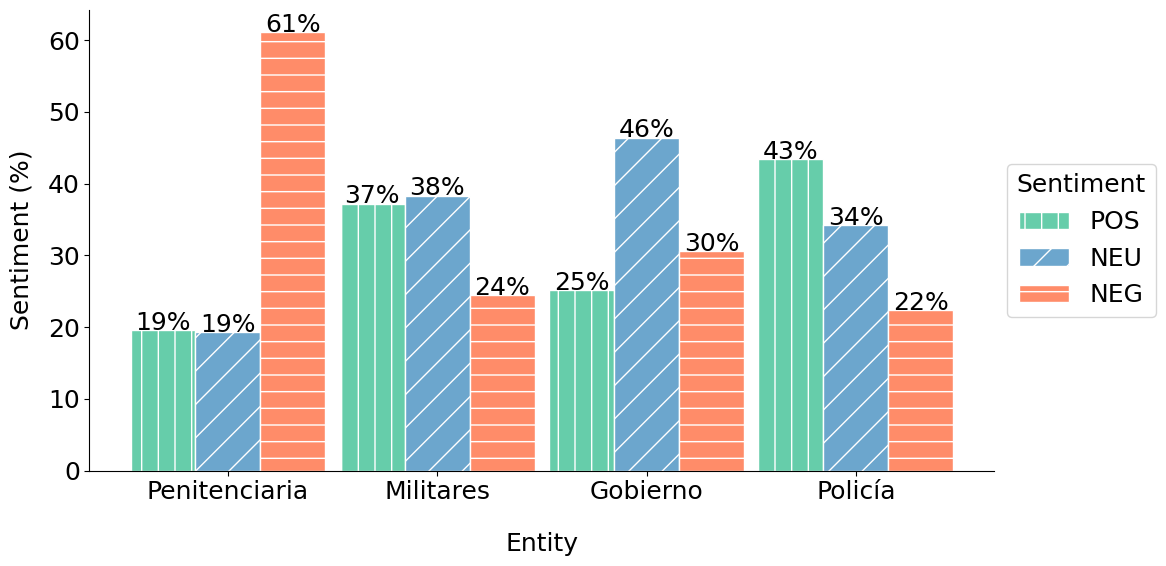

--------------------------------------------------
--------------------------------------------------
['2024-06', '2024-07', '2024-08']
Total Tik Tok opinions: 2598
Total Twitter opinions: 87


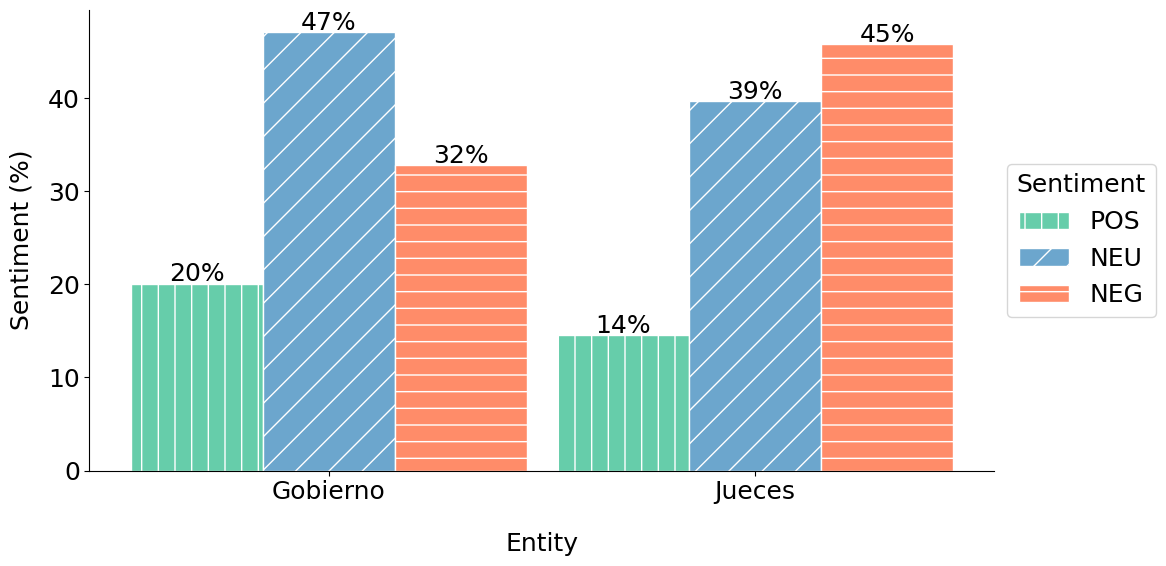

--------------------------------------------------
--------------------------------------------------
['2024-11', '2024-12']
Total Tik Tok opinions: 2522
Total Twitter opinions: 136


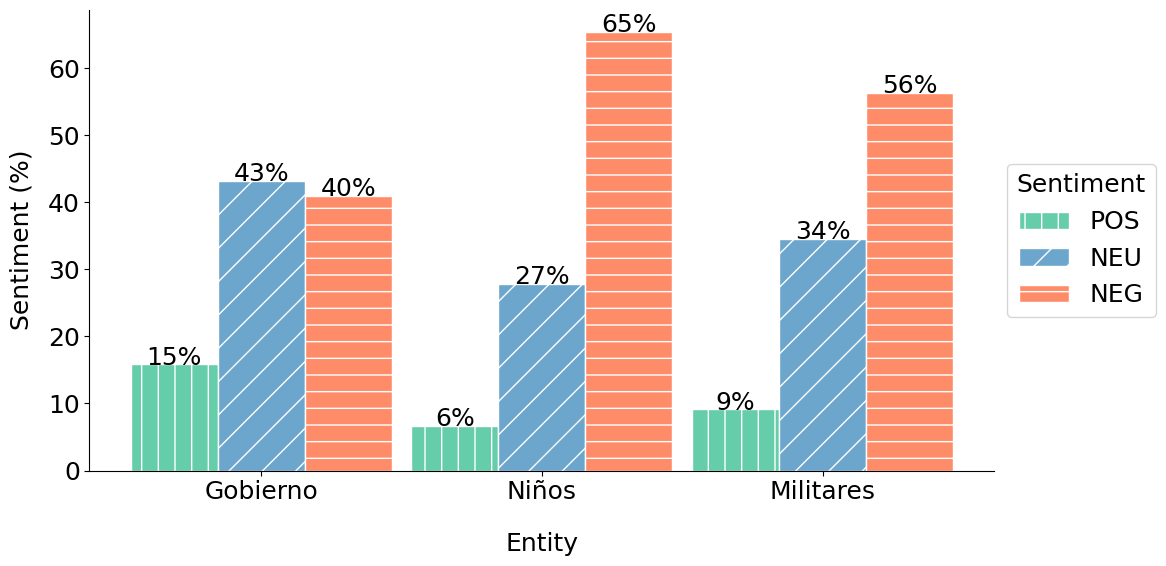

--------------------------------------------------


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

from typing import List

super_map = [
    {
        "range": ["2022-09", "2022-10", "2022-11"],
        "peak_words": [
            {
                "entity": "Penitenciaria",
                "related": [
                    "cárcel",
                    "penitenciaria",
                    "balacera",
                    "penitenciaría",
                    "cárceles",
                    "pabellón",
                    "balaceras",
                    "balacera",
                ],
            },
            {
                "entity": "Gobierno",
                "related": ["presidente", "lasso", "gobierno"],
            },
            # {
            #     "entity": "Tigerones",
            #     "related": ["rulay", "andamos", "tigerón", "tigerones"],
            # },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
        ],
    },
    {
        "range": ["2024-01"],
        "peak_words": [
            {
                "entity": "TC (TV Channel)",
                "related": [
                    "canal",
                    "televisión",
                    "tc",
                    "tctelevision",
                    "ingresaron",
                    "delincuentes",
                    "enero",
                ],
            },
            # {
            #     "entity": "Tigerones",
            #     "related": ["rulay", "andamos", "tigerón", "tigerones"],
            # },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
            {
                "entity": "Policía",
                "related": ["policía", "policías"],
            },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
        ],
    },
    {
        "range": ["2024-03", "2024-04"],
        "peak_words": [
            {
                "entity": "Penitenciaria",
                "related": [
                    "regional",
                    "cárcel",
                    "penitenciaria",
                    "balacera",
                    "penitenciaría",
                    "cárceles",
                    "pabellón",
                    "balaceras",
                    "balacera",
                ],
            },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
            {
                "entity": "Policía",
                "related": ["policía", "policías"],
            },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
        ],
    },
    {
        "range": ["2024-06", "2024-07", "2024-08"],
        "peak_words": [
            {
                "entity": "Jueces",
                "related": [
                    "juez",
                    "jueces",
                    "corruptos",
                    "fiscales",
                    "fiscal",
                    "libres",
                    "leyes",
                ],
            },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
        ],
    },
    {
        "range": ["2024-11", "2024-12"],
        "peak_words": [
            {
                "entity": "Niños",
                "related": [
                    "niños",
                    "niño",
                    "menor",
                    "menores",
                    "malvinas",
                    "padres",
                    # "justicia",
                ],
            },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
        ],
    },
]


# set font size to all plots to 18
plt.rcParams.update({"font.size": 18})

df_tk = pd.read_excel("../data/append_tik_tok_analysis_v4_context.xlsx")
df_tk = df_tk.drop_duplicates(subset="link")
df_tk["scrapped_comments"] = df_tk["comments_text"].apply(
    lambda x: len(str(x).split("|"))
)
df_tk["month-year"] = df_tk["date_parsed"].dt.to_period("M")
total_comments = df_tk["scrapped_comments"].sum()
print(f"Total comments: {total_comments}")

df_x = pd.read_excel("../data/append_tweets_analysis_v4_context.xlsx")
df_x["date_parsed"] = pd.to_datetime(df_x["date_parsed"])
df_x["month-year"] = df_x["date_parsed"].dt.to_period("M")


def calculate_sentiments(
    _df_tiktok: pd.DataFrame, _df_x: pd.DataFrame, _super_map: List[dict]
) -> pd.DataFrame:
    def _min_text(text: str) -> str:
        if text != "nan" and len(text) > 4:
            return True

        return False

    for super_map in _super_map:

        print(f"-" * 50)

        print(super_map["range"])

        _df_filtered = _df_tiktok[
            _df_tiktok["month-year"].isin(pd.Period(x) for x in super_map["range"])
        ]

        opinions = []

        tk_opinions = 0

        for _, row in _df_filtered.iterrows():
            analysis = eval(row["analysis"])

            description_analysis = analysis["description"]

            if (
                _min_text(description_analysis["text"])
                and description_analysis["analysis"]
            ):
                opinions.append(
                    {
                        "text": description_analysis["text"],
                        "probas": description_analysis["analysis"]["probas"],
                    }
                )
                tk_opinions += 1

            for comment in analysis["comments"]:
                if _min_text(comment["text"]) and comment["analysis"]:
                    opinions.append(
                        {
                            "text": comment["text"],
                            "probas": comment["analysis"]["probas"],
                        }
                    )
                    tk_opinions += 1

        print(f"Total Tik Tok opinions: {tk_opinions}")

        x_opinions = 0

        _df_x_filtered = _df_x[
            _df_x["month-year"].isin(pd.Period(x) for x in super_map["range"])
        ]

        for _, row in _df_x_filtered.iterrows():
            analysis = eval(row["analysis"])

            text = analysis["text"]
            analysis = analysis["analysis"]

            if _min_text(text) and analysis:
                opinions.append(
                    {
                        "text": text,
                        "probas": analysis["probas"],
                    }
                )
                x_opinions += 1

        print(f"Total Twitter opinions: {x_opinions}")

        entities_dict = {}

        for opinion in opinions:
            text = opinion["text"]
            probas = opinion["probas"]

            for peak_word in super_map["peak_words"]:
                entity = peak_word["entity"]
                related = peak_word["related"]

                for word in related:
                    if word.lower() in text.lower():
                        if entity not in entities_dict:
                            entities_dict[entity] = {
                                "count": 1,
                                "probas": probas,
                            }
                        else:
                            entities_dict[entity]["count"] += 1
                            for key in probas.keys():
                                entities_dict[entity]["probas"][key] += probas[key]

        entities_mean = []

        for entity, data in entities_dict.items():
            mean_probas = {
                key: data["probas"][key] / data["count"]
                for key in data["probas"].keys()
            }

            entities_mean.append(
                {
                    "entity": entity,
                    "pos": mean_probas["POS"],
                    "neg": mean_probas["NEG"],
                    "neu": mean_probas["NEU"],
                }
            )

        # plot a stacked bar chart with the sentiment of each entity and inside of each stack shwo the percentage of each sentiment
        df_entities = pd.DataFrame(entities_mean)

        df_entities = df_entities.set_index("entity")

        # Definir colores y texturas
        colors = {"pos": "#66CDAA", "neg": "#FF8C69", "neu": "#6CA6CD"}
        #colors = {"pos": "#2ca02c", "neg": "#ff7f0e", "neu": "#1f77b4"}
        hatches = {"pos": "|", "neg": "-", "neu": "/"}

        # Crear el gráfico de barras agrupadas
        _, ax = plt.subplots(figsize=(16, 8))
        bar_width = 0.31
        index = pd.Index(range(len(df_entities)))
        for i, sentiment in enumerate(["pos", "neu", "neg" ]):
            ax.bar(
                index + i * bar_width,
                df_entities[sentiment] * 100,
                color=colors[sentiment],
                hatch=hatches[sentiment],
                width=bar_width,
                label=sentiment.upper(),
                edgecolor='white',
            )

        # Añadir los valores dentro de las barras
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            if height > 0:
                ax.text(
                    x + width / 2,
                    y + height + 1,
                    f"{int(height)}%",
                    ha="center",
                    va="center",
                )

        plt.gcf().set_size_inches(12, 6)

        # Eliminar los bordes superior y derecho
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.set_xticks(index + bar_width)
        ax.set_xticklabels(df_entities.index, rotation=0, ha="center")

        text = " ".join(super_map["range"])
        plt.xlabel("Entity", labelpad=20)
        plt.ylabel("Sentiment (%)", labelpad=10)
        # plt.title(f"Sentiment of peak entities in {text}", pad=20)
        plt.legend(title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig(f"../imgs/tik_tok_sentiment_{text}_V2_LIGHT.png", dpi=300)
        plt.show()
        print(f"-" * 50)


calculate_sentiments(df_tk, df_x, super_map)